In [1]:
import numpy
import xarray
import matplotlib
import matplotlib.pyplot as mp
import datetime
import matplotlib.colors
import scipy.stats
import itertools
import string
import matplotlib.patches
import netCDF4
import cftime
import seaborn
import cmocean
import matplotlib.gridspec
import scipy.interpolate

import glob
import pandas

import mpl_toolkits
import cartopy

DEGREE_SIGN = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})

In [2]:
dry_lon_lo, dry_lon_hi, dry_lat_lo, dry_lat_hi = -60,-50,-7.5,10
wet_lon_lo, wet_lon_hi, wet_lat_lo, wet_lat_hi = -80,-75,-7.5,10

dry_lon_lo_degE = 360+dry_lon_lo
dry_lon_hi_degE = 360+dry_lon_hi

wet_lon_lo_degE = 360+wet_lon_lo
wet_lon_hi_degE = 360+wet_lon_hi

calculate latitude information

In [3]:
lat_lo_open = -35.
lat_hi_open = 35.
lat_lo = -10.
lat_hi = 10.
lon_lo = 270.
lon_hi = 330.

# 10year simulations

400 clm runs

In [4]:
data_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm0400/'
cont_cam_mfds = xarray.open_mfdataset(data_dir + 'atm/hist/*.nc', decode_times=False, decode_cf=False, concat_dim='time')

In [5]:
root_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm0400/'
file_list = sorted(glob.glob(root_dir+'lnd/hist/*.nc'))
cont_clm_ds_list = [xarray.open_dataset(file, decode_times=False) for file in file_list]

In [6]:
SOILLIQ_400_list = [f['SOILLIQ'].values for f in cont_clm_ds_list]
SOILWATER_400_list = [f['SOILWATER_10CM'].values for f in cont_clm_ds_list]

get lat/lon info

In [7]:
lat = cont_clm_ds_list[0]['lat'].sel(lat=slice(lat_lo_open,lat_hi_open)).values
lon = cont_clm_ds_list[0]['lon'].sel(lon=slice(lon_lo,lon_hi)).values

lon_total = cont_clm_ds_list[0]['lon'].values
lat_total = cont_clm_ds_list[0]['lat'].values

lat_indices = (lat>=lat_lo)&(lat<=lat_hi)
lat_indices_open = (lat>=lat_lo_open)&(lat<=lat_hi_open)
lon_indices = (lon>=lon_lo)&(lon<=lon_hi)

lat_subset = lat[lat_indices]
lon_subset = lon[lon_indices]

lat_subset_open = lat[lat_indices_open]

get time info

In [8]:
time_400_list = [netCDF4.num2date(ds['time'].values, \
                                  ds['time'].units, \
                                  ds['time'].calendar) \
                 for ds in cont_clm_ds_list]

In [9]:
time_400_array = numpy.array([ t for sublist in time_400_list for t in sublist ])

In [10]:
time_400 = cont_cam_mfds['time']
time_converted = netCDF4.num2date(time_400.values, time_400.units, time_400.calendar)

time_manual = []
for t_idx in range(time_converted.size):
    year=time_converted[t_idx].year
    month=time_converted[t_idx].month
    day=time_converted[t_idx].day
    hour=time_converted[t_idx].hour
    minute=time_converted[t_idx].minute
    hour_round = round(hour+minute/60)
    time_manual.append(cftime.DatetimeNoLeap(year,month,day,hour_round))

In [11]:
LANDFRAC = cont_cam_mfds['LANDFRAC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values[0,:,:]

In [12]:
PRECC_400_10y = cont_cam_mfds['PRECC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECL_400_10y = cont_cam_mfds['PRECL'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECT_400_10y = PRECC_400_10y+PRECL_400_10y

1000 clm runs

In [13]:
data_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm1000/'
phys_cam_mfds = xarray.open_mfdataset(data_dir + 'atm/hist/*.nc', decode_times=False, parallel=True)

In [14]:
root_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm1000/'
file_list = sorted(glob.glob(root_dir+'lnd/hist/*.nc'))
phys_clm_ds_list = [xarray.open_dataset(file, decode_times=False) for file in file_list]

In [15]:
cesm_soil_levels = phys_clm_ds_list[0]['levgrnd'].values*100. # units: meters, change to centimeters

In [16]:
SOILLIQ_1000_list = [f['SOILLIQ'].values for f in phys_clm_ds_list]
SOILWATER_1000_list = [f['SOILWATER_10CM'].values for f in phys_clm_ds_list]

In [17]:
PRECC_1000_10y = phys_cam_mfds['PRECC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECL_1000_10y = phys_cam_mfds['PRECL'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECT_1000_10y = PRECC_1000_10y+PRECL_1000_10y

take time averages

In [18]:
PRECT_400_timemean_10year = numpy.mean(PRECT_400_10y, axis=0)
PRECT_1000_timemean_10year = numpy.mean(PRECT_1000_10y, axis=0)

In [19]:
PRECT_400_timemean_10year_landmask = numpy.copy(PRECT_400_timemean_10year)
PRECT_1000_timemean_10year_landmask = numpy.copy(PRECT_1000_timemean_10year)

PRECT_400_timemean_10year_landmask[LANDFRAC==0] = numpy.nan
PRECT_1000_timemean_10year_landmask[LANDFRAC==0] = numpy.nan

# calculate all cesm differences

precip

In [20]:
PRECT_diffs_10year = PRECT_1000_timemean_10year_landmask-PRECT_400_timemean_10year_landmask

soil moisture

In [21]:
SOILWATER_400 = numpy.concatenate(SOILWATER_400_list, axis=0)
SOILWATER_1000 = numpy.concatenate(SOILWATER_1000_list, axis=0)

In [22]:
SOILLIQ_400 = numpy.concatenate(SOILLIQ_400_list, axis=0)
SOILLIQ_1000 = numpy.concatenate(SOILLIQ_1000_list, axis=0)

In [23]:
SOILWATER_400_timemean = numpy.nanmean(SOILWATER_400, axis=0)
SOILWATER_1000_timemean = numpy.nanmean(SOILWATER_1000, axis=0)
SOILWATER_diffs_10year = SOILWATER_1000_timemean-SOILWATER_400_timemean

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [24]:
SOILLIQ_400_timemean = numpy.nanmean(SOILLIQ_400, axis=0)
SOILLIQ_1000_timemean = numpy.nanmean(SOILLIQ_1000, axis=0)
SOILLIQ_diffs_10year = SOILLIQ_1000_timemean-SOILLIQ_400_timemean

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


# now also open WRF

400 ppm

In [25]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/400/ens_mean_wrfout_files'
file_list = glob.glob(root_dir+'/'+'wrfout*.nc')
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [26]:
cont_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [27]:
time = cont_mfds['Times'].values
xlat = cont_mfds['XLAT'].values[0,:,:]
xlong = cont_mfds['XLONG'].values[0,:,:]
landmask = cont_mfds['LANDMASK'].values[0,:,:]
landmask_midpoints = landmask[1:,1:]

In [28]:
landmask_indices = numpy.copy(landmask)
landmask_indices[landmask==1]=1
landmask_indices[landmask!=1]=0
landmask_indices = numpy.array(landmask_indices, dtype=bool)

In [29]:
rainc_400 = cont_mfds['RAINC'].values
rainnc_400 = cont_mfds['RAINNC'].values
soilh2o_400 = cont_mfds['SH2O'].values

In [30]:
raintot_400 = rainc_400+rainnc_400

In [31]:
cont_mfds['ZS']

<xarray.DataArray 'ZS' (Time: 241, soil_layers_stag: 4)>
dask.array<shape=(241, 4), dtype=float32, chunksize=(24, 4)>
Coordinates:
    XTIME    (Time) datetime64[ns] dask.array<shape=(241,), chunksize=(24,)>
Dimensions without coordinates: Time, soil_layers_stag
Attributes:
    FieldType:    104
    MemoryOrder:  Z  
    description:  DEPTHS OF CENTERS OF SOIL LAYERS
    units:        m
    stagger:      Z

In [32]:
wrf_soil_layers_ctr = cont_mfds['ZS'].isel(Time=0).values

In [33]:
wrf_soil_layers_ctr*100

array([  5.     ,  25.     ,  70.00001, 150.     ], dtype=float32)

In [34]:
cont_mfds['SH2O']

<xarray.DataArray 'SH2O' (Time: 241, soil_layers_stag: 4, south_north: 179, west_east: 289)>
dask.array<shape=(241, 4, 179, 289), dtype=float32, chunksize=(24, 4, 179, 289)>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<shape=(241, 179, 289), chunksize=(24, 179, 289)>
    XLONG    (Time, south_north, west_east) float32 dask.array<shape=(241, 179, 289), chunksize=(24, 179, 289)>
    XTIME    (Time) datetime64[ns] dask.array<shape=(241,), chunksize=(24,)>
Dimensions without coordinates: Time, soil_layers_stag, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  SOIL LIQUID WATER
    units:        m3 m-3
    stagger:      Z

1000 ppm

In [35]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/ens_mean_wrfout_files'
file_list = glob.glob(root_dir+'/'+'wrfout*.nc')
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [36]:
phys_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [37]:
rainc_1000 = phys_mfds['RAINC'].values
rainnc_1000 = phys_mfds['RAINNC'].values
soilh2o_1000 = phys_mfds['SH2O'].values

In [38]:
raintot_1000 = rainc_1000+rainnc_1000

wrf time stamp info

In [39]:
time_datetimes = pandas.to_datetime([i.decode('utf-8') for i in time], format = '%Y-%m-%d_%H:%M:%S')

In [40]:
rainc_diffs = rainc_1000-rainc_400
rainnc_diffs = rainnc_1000-rainnc_400
soilh2o_diffs = soilh2o_1000-soilh2o_400
raintot_diffs = raintot_1000-raintot_400

# plot 10-year mean changes

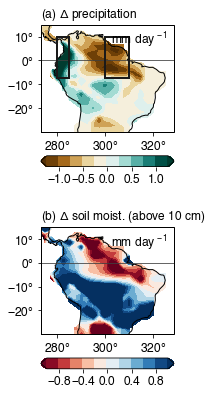

In [41]:
# MONTHLY MEAN PLOTS

fig = mp.figure(figsize=(2.667,6))
fontsize = 12
lon_offset=25.

# PRECIP DIFFS

levels = numpy.arange(-1.25,1.251,0.25)
ax1 = fig.add_subplot(211, projection=cartopy.crs.PlateCarree())
ax1.gridlines(ylocs=[0], color='0.25')
ax1.coastlines(resolution='110m')
contour_plot1 = ax1.contourf(lon, lat, PRECT_diffs_10year*86400.*1000., \
                             levels=levels, \
                             cmap='BrBG', extend='both', transform=cartopy.crs.PlateCarree())

# ax1.contour(lon,lat,field_convolved*24.,\
#             levels=[4], colors=outline_color, linewidths=[2], linestyles=['-'])

# left patch
ax1.add_patch(matplotlib.patches.Rectangle(xy=[wet_lon_lo, wet_lat_lo], width=(wet_lon_hi-wet_lon_lo), \
                                           height=(wet_lat_hi-wet_lat_lo),
                                facecolor='none',
                                edgecolor='0.1',\
                                linewidth=2,\
                                transform=cartopy.crs.PlateCarree(), zorder=2) )

ax1.add_patch(matplotlib.patches.Rectangle(xy=[dry_lon_lo, dry_lat_lo], width=(dry_lon_hi-dry_lon_lo), \
                                           height=(dry_lat_hi-dry_lat_lo),
                                facecolor='none',
                                edgecolor='0.1',\
                                linewidth=2,\
                                transform=cartopy.crs.PlateCarree(), zorder=2) )

# CHANGE IN SOIL MOISTURE

levels = numpy.arange(-1,1.1,0.2)
ax2 = fig.add_subplot(212, projection=cartopy.crs.PlateCarree())
ax2.gridlines(ylocs=[0], color='0.25')
ax2.coastlines(resolution='110m')
contour_plot2 = ax2.contourf(lon_total, lat_total, SOILWATER_diffs_10year, levels=levels, \
                             cmap='RdBu', extend='both', transform=cartopy.crs.PlateCarree())

ax1.set_extent([273,329,-30,15], crs=cartopy.crs.PlateCarree())
ax2.set_extent([273,329,-30,15], crs=cartopy.crs.PlateCarree())

ax1.set_xticks([-360+280,-360+300,-360+320])
ax1.set_yticks([-20,-10,0,10])
ax1.tick_params(labelsize=fontsize)
ax1.set_xticklabels(['$280$'+DEGREE_SIGN,'$300$'+DEGREE_SIGN,'$320$'+DEGREE_SIGN])
ax1.set_yticklabels(['$-20$'+DEGREE_SIGN,'$-10$'+DEGREE_SIGN,'$0$'+DEGREE_SIGN,'$10$'+DEGREE_SIGN])

ax2.set_xticks([-360+280,-360+300,-360+320])
ax2.set_yticks([-20,-10,0,10])
ax2.tick_params(labelsize=fontsize)
ax2.set_xticklabels(['$280$'+DEGREE_SIGN,'$300$'+DEGREE_SIGN,'$320$'+DEGREE_SIGN])
ax2.set_yticklabels(['$-20$'+DEGREE_SIGN,'$-10$'+DEGREE_SIGN,'$0$'+DEGREE_SIGN,'$10$'+DEGREE_SIGN])

fig.tight_layout(h_pad=0.5,w_pad=0.5)
fig.canvas.draw_idle()

title = ax1.text(s='(a) $\Delta$ precipitation', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax1.transAxes)
title = ax2.text(s='(b) $\Delta$ soil moist. (above 10 cm)', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax2.transAxes)

ax1.text(s='mm day$^{\,-1}$', x=0.95, y=0.95, \
        ha='right', va='top', \
        fontsize=fontsize, \
        transform=ax1.transAxes)
ax2.text(s='mm day$^{\,-1}$', x=0.95, y=0.95, \
        ha='right', va='top', \
        fontsize=fontsize, \
        transform=ax2.transAxes)

for c in contour_plot1.collections:
    c.set_edgecolor('face')
    c.set_rasterized(True)
for c in contour_plot2.collections:
    c.set_edgecolor('face')
    c.set_rasterized(True)

cbar_thickness=0.025
cbar_yshift=-0.08

#fig.tight_layout()

bbox_position = ax1.get_position()
cbar_axes = fig.add_axes([bbox_position.x0, bbox_position.y0+cbar_yshift, bbox_position.width, cbar_thickness])
cbar = mp.colorbar(contour_plot1, orientation='horizontal', cax=cbar_axes)
cbar_axes.tick_params(labelsize=fontsize)
cbar.set_ticks([numpy.arange(-1,1.1,0.5)])
for c in cbar_axes.collections:
    c.set_edgecolor('face')
#     c.set_rasterized(True)

bbox_position = ax2.get_position()
cbar_axes = fig.add_axes([bbox_position.x0, bbox_position.y0+cbar_yshift, bbox_position.width, cbar_thickness])
cbar = mp.colorbar(contour_plot2, orientation='horizontal', cax=cbar_axes)
cbar_axes.tick_params(labelsize=fontsize)
for c in cbar_axes.collections:
    c.set_edgecolor('face')
#     c.set_rasterized(True)

#fig.savefig('../figures/REVISION_fig02.pdf', dpi=300, transparent=True, bbox_inches='tight')

In [42]:
SOILLIQ_diffs_10year.shape

(15, 96, 144)

subset wrf

In [43]:
xlat_subset_indices_dry = (xlat>=dry_lat_lo)&(xlat<=dry_lat_hi)
xlong_subset_indices_dry = (xlong>=dry_lon_lo)&(xlong<=dry_lon_hi)

xlat_xlong_indices_dry = (xlat_subset_indices_dry)&(xlong_subset_indices_dry)&(landmask==1)

In [44]:
xlat_subset_indices_wet = (xlat>=wet_lat_lo)&(xlat<=wet_lat_hi)
xlong_subset_indices_wet = (xlong>=wet_lon_lo)&(xlong<=wet_lon_hi)

xlat_xlong_indices_wet = (xlat_subset_indices_wet)&(xlong_subset_indices_wet)&(landmask==1)

In [45]:
soilh2o_1000_dry = soilh2o_1000[:,:,xlat_xlong_indices_dry]
soilh2o_400_dry = soilh2o_400[:,:,xlat_xlong_indices_dry]

soilh2o_1000_wet = soilh2o_1000[:,:,xlat_xlong_indices_wet]
soilh2o_400_wet = soilh2o_400[:,:,xlat_xlong_indices_wet]

In [46]:
soilh2o_1000_dry_areamean = numpy.nanmean(soilh2o_1000_dry, axis=(2))
soilh2o_400_dry_areamean = numpy.nanmean(soilh2o_400_dry, axis=(2))

In [47]:
soilh2o_1000_wet_areamean = numpy.nanmean(soilh2o_1000_wet, axis=(2))
soilh2o_400_wet_areamean = numpy.nanmean(soilh2o_400_wet, axis=(2))

In [48]:
soilh2o_wet_diffs = soilh2o_1000_wet_areamean-soilh2o_400_wet_areamean
soilh2o_dry_diffs = soilh2o_1000_dry_areamean-soilh2o_400_dry_areamean

subset cesm

In [49]:
lat_subset_indices_dry = (lat>=dry_lat_lo)&(lat<=dry_lat_hi)
lon_subset_indices_dry = (lon>=dry_lon_lo_degE)&(lon<=dry_lon_hi_degE)

lat_total_indices_dry = (lat_total>=dry_lat_lo)&(lat_total<=dry_lat_hi)
lon_total_indices_dry = (lon_total>=dry_lon_lo_degE)&(lon_total<=dry_lon_hi_degE)

In [50]:
lat_subset_indices_wet = (lat>=wet_lat_lo)&(lat<=wet_lat_hi)
lon_subset_indices_wet = (lon>=wet_lon_lo_degE)&(lon<=wet_lon_hi_degE)

lat_total_indices_wet = (lat_total>=wet_lat_lo)&(lat_total<=wet_lat_hi)
lon_total_indices_wet = (lon_total>=wet_lon_lo_degE)&(lon_total<=wet_lon_hi_degE)

In [51]:
PRECT_1000_dry = PRECT_1000_10y[:,lat_subset_indices_dry,:][:,:,lon_subset_indices_dry]
PRECT_400_dry = PRECT_400_10y[:,lat_subset_indices_dry,:][:,:,lon_subset_indices_dry]

PRECT_1000_wet = PRECT_1000_10y[:,lat_subset_indices_wet,:][:,:,lon_subset_indices_wet]
PRECT_400_wet = PRECT_400_10y[:,lat_subset_indices_wet,:][:,:,lon_subset_indices_wet]

In [52]:
SOILWATER_1000_dry = SOILWATER_1000[:,lat_total_indices_dry,:][:,:,lon_total_indices_dry]
SOILWATER_400_dry = SOILWATER_400[:,lat_total_indices_dry,:][:,:,lon_total_indices_dry]

SOILWATER_1000_wet = SOILWATER_1000[:,lat_total_indices_wet,:][:,:,lon_total_indices_wet]
SOILWATER_400_wet = SOILWATER_400[:,lat_total_indices_wet,:][:,:,lon_total_indices_wet]

In [53]:
SOILLIQ_1000_dry = SOILLIQ_1000[:,:,lat_total_indices_dry,:][:,:,:,lon_total_indices_dry]
SOILLIQ_400_dry = SOILLIQ_400[:,:,lat_total_indices_dry,:][:,:,:,lon_total_indices_dry]

SOILLIQ_1000_wet = SOILLIQ_1000[:,:,lat_total_indices_wet,:][:,:,:,lon_total_indices_wet]
SOILLIQ_400_wet = SOILLIQ_400[:,:,lat_total_indices_wet,:][:,:,:,lon_total_indices_wet]

In [54]:
PRECT_1000_dry_areamean = numpy.nanmean(PRECT_1000_dry, axis=(1,2))
PRECT_400_dry_areamean = numpy.nanmean(PRECT_400_dry, axis=(1,2))

In [55]:
SOILWATER_1000_dry_areamean = numpy.nanmean(SOILWATER_1000_dry, axis=(1,2))
SOILWATER_400_dry_areamean = numpy.nanmean(SOILWATER_400_dry, axis=(1,2))

In [56]:
SOILLIQ_1000_dry_areamean = numpy.nanmean(SOILLIQ_1000_dry, axis=(2,3))
SOILLIQ_400_dry_areamean = numpy.nanmean(SOILLIQ_400_dry, axis=(2,3))

In [57]:
SOILWATER_dry_diffs = SOILWATER_1000_dry_areamean-SOILWATER_400_dry_areamean
PRECT_dry_diffs = PRECT_1000_dry_areamean-PRECT_400_dry_areamean
SOILLIQ_dry_diffs = SOILLIQ_1000_dry_areamean - SOILLIQ_400_dry_areamean

In [58]:
SOILWATER_dry_diffs_rollingmean = pandas.Series(SOILWATER_dry_diffs).rolling(window=365, center=True, min_periods=1).mean()
PRECT_dry_diffs_rollingmean = pandas.Series(PRECT_dry_diffs).rolling(window=365, center=True, min_periods=1).mean()

In [59]:
which_level = 7
SOILLIQ_dry_diffs_rollingmean = pandas.Series(SOILLIQ_dry_diffs[:,which_level]).rolling(window=365, center=True, min_periods=1).mean()

# wrf analysis

In [60]:
soilh2o_diffs.shape

(241, 4, 179, 289)

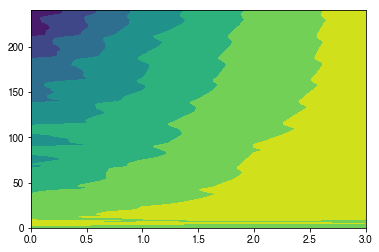

In [61]:
mp.contourf(soilh2o_dry_diffs)

In [62]:
soilh2o_dry_diffs.shape

(241, 4)

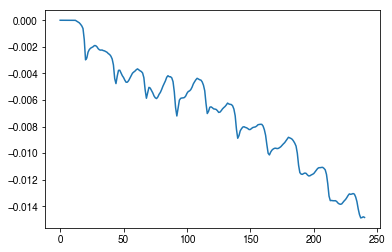

In [63]:
mp.plot(soilh2o_dry_diffs[:,0])

In [64]:
wrf_soil_levels = [10,40,100,200]

In [65]:
cesm_soil_levels

array([7.10063517e-01, 2.79250002e+00, 6.22585773e+00, 1.18865061e+01,
       2.12193394e+01, 3.66065788e+01, 6.19758492e+01, 1.03802704e+02,
       1.72763519e+02, 2.86460724e+02, 4.73915680e+02, 7.82976624e+02,
       1.29253210e+03, 2.13264697e+03, 3.51776196e+03], dtype=float32)

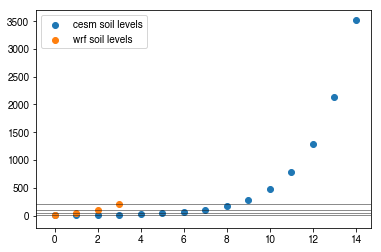

In [66]:
mp.scatter(numpy.arange(cesm_soil_levels.size), cesm_soil_levels, label='cesm soil levels')
mp.scatter(numpy.arange(wrf_soil_levels.__len__()), wrf_soil_levels, label='wrf soil levels')
for lev in wrf_soil_levels:
    mp.axhline(lev, lw=0.5, c='0.1')
#mp.ylim(0,300)
mp.legend()

    WRF         CESM
    layer 0     layers 3,4 (ind 2,3)
    layer 1     layers 6 (ind 5)
    layer 3     layer 8 (ind 7)
    layer 4     layer 9,10 (ind 8,9)

In [67]:
cesm_soil_levels_diffs = numpy.diff(numpy.hstack((numpy.array(0.0), cesm_soil_levels)))
layer1_thickness = numpy.mean(cesm_soil_levels_diffs[2:4])/100.
layer2_thickness = numpy.mean(cesm_soil_levels_diffs[5])/100.
layer3_thickness = numpy.mean(cesm_soil_levels_diffs[7])/100.
layer4_thickness = numpy.mean(cesm_soil_levels_diffs[8:10])/100.
layer_thickness_cesm = numpy.array([layer1_thickness, layer2_thickness, layer3_thickness, layer4_thickness])

In [68]:
layer1_depth = numpy.mean(cesm_soil_levels[2:4])/100.
layer2_depth = numpy.mean(cesm_soil_levels[5])/100.
layer3_depth = numpy.mean(cesm_soil_levels[7])/100.
layer4_depth = numpy.mean(cesm_soil_levels[8:10])/100.
layer_depth_cesm = numpy.array([layer1_depth, layer2_depth, layer3_depth, layer4_depth])

In [69]:
cesm_equiv_1 = numpy.average(SOILLIQ_dry_diffs[:,[2,3]], axis=1, weights=cesm_soil_levels[1:3])
cesm_equiv_2 = numpy.average(SOILLIQ_dry_diffs[:,[4,5]], axis=1, weights=cesm_soil_levels[7:9])
cesm_equiv_3 = SOILLIQ_dry_diffs[:,6]
cesm_equiv_4 = SOILLIQ_dry_diffs[:,7]

cesm_equiv_soilh2o = numpy.array([cesm_equiv_1, cesm_equiv_2, cesm_equiv_3, cesm_equiv_4])
cesm_equiv_soilh2o = (cesm_equiv_soilh2o.T/(1000*layer_thickness_cesm)).T

In [70]:
wrf_soil_levels

[10, 40, 100, 200]

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,'WRF soil moisture changes')

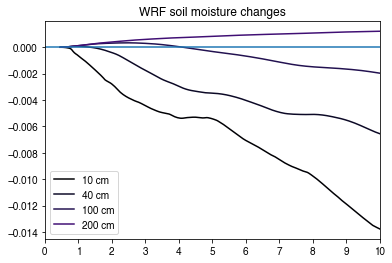

In [71]:
color_list = [matplotlib.cm.magma(i) for i in numpy.linspace(0,1,SOILLIQ_dry_diffs.shape[1])]
for i in range(soilh2o_dry_diffs.shape[1]):
    plot_this = pandas.Series(soilh2o_dry_diffs[:,i]).rolling(window=24, min_periods=12).mean()
    mp.plot(plot_this, color=color_list[i], label='{:.0f} cm'.format(wrf_soil_levels[i])) #SOILLIQ_dry_diffs[:,1])#
mp.xlim(0,240)
mp.xticks([i for i in range(0,241,24)])
mp.axes().set_xticklabels([i for i in range(0,11,1)])
#mp.ylim(-.8,.2)
mp.axhline(0)
mp.legend()
mp.title('WRF soil moisture changes')

In [72]:
cesm_equiv_soilh2o.shape

(4, 3651)

Text(0.5,1,'CESM soil moisture changes')

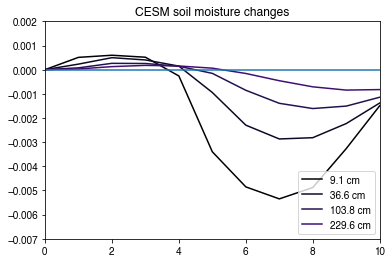

In [73]:
color_list = [matplotlib.cm.magma(i) for i in numpy.linspace(0,1,SOILLIQ_dry_diffs.shape[1])]
for i in range(4):
    mp.plot(cesm_equiv_soilh2o[i,:], color=color_list[i], label='{:.1f} cm'.format(layer_depth_cesm[i]*100.)) #SOILLIQ_dry_diffs[:,1])#
mp.xlim(0,10)
mp.ylim(-.007,.002)
mp.axhline(0)
mp.legend(loc=4)
mp.title('CESM soil moisture changes')

In [74]:
SOILLIQ_dry_diffs.shape

(3651, 15)

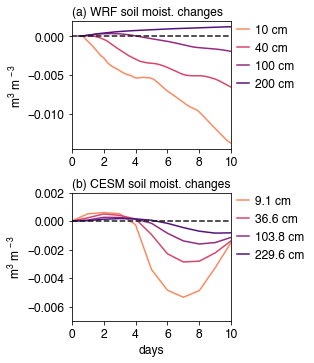

In [75]:
fig = mp.figure(figsize=(4.5,5))
color_list = [matplotlib.cm.magma(i) for i in numpy.linspace(0.25,0.75,4)][::-1]

ax = fig.add_subplot(211)

for i in range(soilh2o_dry_diffs.shape[1]):
    plot_this = pandas.Series(soilh2o_dry_diffs[:,i]).rolling(window=24, min_periods=12).mean()
    ax.plot(plot_this, color=color_list[i], label='{:.0f} cm'.format(wrf_soil_levels[i])) #SOILLIQ_dry_diffs[:,1])#
ax.set_xlim(0,240)
ax.set_xticks([i for i in range(0,241,48)])
ax.set_xticklabels([i for i in range(0,11,2)])
ax.set_yticks(numpy.arange(0,-.011,-0.005))
ax.set_ylabel('m$^3$ m$^{\,-3}$', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.axhline(0, ls='--', c='0.1')
ax.legend()

ax.text(s='(a) WRF soil moist. changes', x=0, y=1.02, \
        ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, fontsize=fontsize, ncol=1, \
                   bbox_to_anchor=(1.02,1.0), edgecolor='None', facecolor='None', \
                   fancybox=False, bbox_transform=ax.transAxes, loc='upper left', \
                   borderaxespad=0, borderpad=0.25, handlelength=1.0, \
                   handletextpad=0.5)

ax = fig.add_subplot(212)

for i in range(4):
    ax.plot(cesm_equiv_soilh2o[i,:], color=color_list[i], label='{:.1f} cm'.format(layer_depth_cesm[i]*100.)) #SOILLIQ_dry_diffs[:,1])#
ax.set_xlim(0,10)
ax.set_ylim(-.007,.002)
ax.axhline(0, ls='--', c='0.1')
ax.set_ylabel('m$^3$ m$^{\,-3}$', fontsize=fontsize)
ax.set_xlabel('days', fontsize=fontsize)
ax.set_xticks([i for i in range(0,11,2)])
ax.tick_params(labelsize=fontsize)
ax.legend(loc=4)

ax.text(s='(b) CESM soil moist. changes', x=0, y=1.02, \
        ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, fontsize=fontsize, ncol=1, \
                   bbox_to_anchor=(1.02,1.0), edgecolor='None', facecolor='None', \
                   fancybox=False, bbox_transform=ax.transAxes, loc='upper left', \
                   borderaxespad=0, borderpad=0.25, handlelength=1.0, \
                   handletextpad=0.5)

fig.tight_layout(h_pad=2)
#ax.title('CESM soil moisture changes')

fig.savefig('../figures/REVISION_fig??_soil_moisture_timeseries_10days.pdf', bbox_inches='tight',\
           transparent=True)

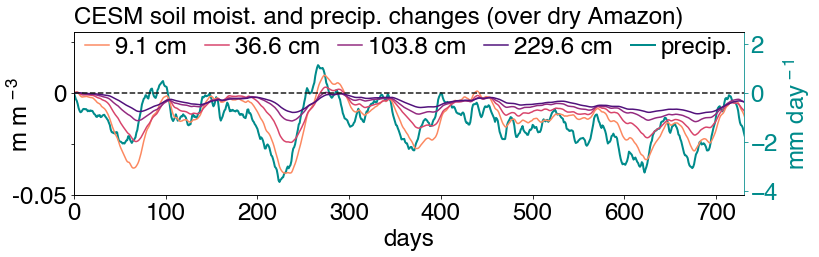

In [107]:
fontsize = 24

color_list = [matplotlib.cm.magma(i) for i in numpy.linspace(0.25,0.75,4)][::-1]

fig = mp.figure(figsize=(12,3))

ax = fig.add_subplot(111)
for i in range(4):
    plot_this = pandas.Series(cesm_equiv_soilh2o[i,:]).rolling(window=30, min_periods=1).mean()
    ax.plot(plot_this, color=color_list[i], label='{:.1f} cm'.format(layer_depth_cesm[i]*100.)) #SOILLIQ_dry_diffs[:,1])#
ax.set_xlim(0,730)
ax.set_ylim(-.05,0.03)
ax.axhline(0, ls='--', c='0.1')
ax.legend(loc=4)
ax.text(s='CESM soil moist. and precip. changes (over dry Amazon)', x=0, y=1.02,\
        ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.set_xlabel('days', fontsize=fontsize)
ax.set_ylabel('m m$^{\,-3}$', fontsize=fontsize, labelpad=-20)
ax.tick_params(labelsize=fontsize)
ax.set_yticks([-.05,-.025,0,.025])
ax.set_yticklabels(['-0.05','','0',''])
ax.spines['right'].set_color(None)
ax.zorder=1
ax.set_facecolor('None')
ymin, ymax = ax.get_ylim()

handles, labels = ax.get_legend_handles_labels()

precip_color='darkcyan'
ax2 = ax.twinx()
plot_this = pandas.Series(PRECT_dry_diffs*86400.*1000.).rolling(window=30, min_periods=1).mean()
ax2.plot(plot_this, color=precip_color, lw='2', label='precip.')
ax2.set_ylabel('mm day$^{\,-1}$', color=precip_color, fontsize=fontsize)
ax2.set_yticks([-4,-2,0,2])
ax2.set_facecolor('None')
ax2.zorder=0
ax2.tick_params(labelsize=fontsize)
ax2.tick_params(axis='y', color=precip_color)
ax2.spines['right'].set_color(precip_color)
[t.set_color(precip_color) for t in ax2.yaxis.get_ticklabels()]

handles2, labels2 = ax2.get_legend_handles_labels()

handles = handles+handles2
labels = labels+labels2
legend = ax.legend(handles, labels, fontsize=fontsize, ncol=5, \
                   bbox_to_anchor=(.5,.97), edgecolor='None', facecolor='None', \
                   fancybox=False, bbox_transform=ax.transAxes, loc='upper center', \
                   borderaxespad=0, borderpad=0., handlelength=1., \
                   handletextpad=0.25, columnspacing=0.75)

# make the zeros line up
zero_to_ymax_ratio = (ymax-0)/(ymax-ymin)
ymax2 = 2.5
ymin2 = ymax2-(ymax2/zero_to_ymax_ratio)
ax2.set_ylim(ymin2,ymax2)

fig.savefig('../figures/POSTER_soil_moisture_time_series.pdf', bbox_inches='tight',\
           transparent=True)